In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
from PIL import Image

In [3]:
Training_original="/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/Training_original/Training_original/Training_original"
Training_Fake="/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/Training_original/Training_original/Training_original"
Validation_original="/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/Validation_original/Validation_original/Validation_original"
Validation_Fake="/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/Validation_fake/Validation_fake/Validation_fake"

In [4]:
images_original = []
images_fake = []

In [5]:


# Loop through all files in the folder
for filename in os.listdir(Training_original):
    if filename.endswith((".jpg")):  # Check for common image extensions
        # Open the image file
        image_path = os.path.join(Training_original, filename)
        img = Image.open(image_path)
        images_original.append(img)

# Output the number of images loaded
print(f"Total number of Training original images loaded: {len(images_original)}")


# Loop through all files in the folder
for filename in os.listdir(Training_Fake):
    if filename.endswith((".jpg")):  # Check for common image extensions
        # Open the image file
        image_path = os.path.join(Training_Fake, filename)
        img = Image.open(image_path)
        images_fake.append(img)

# Output the number of images loaded
print(f"Total number of Training fake images loaded: {len(images_fake)}")

Total number of Training original images loaded: 2036
Total number of Training fake images loaded: 2036


In [6]:
import numpy as np
from sklearn.utils import shuffle

# Assuming images are PIL Image objects, resize them if needed to reduce memory usage
def preprocess_image(image, target_size=(128, 128)):
    # Resize and convert to numpy array
    return np.array(image.resize(target_size)) / 255.0  # Normalize pixel values

# Preprocess images to reduce memory usage
images_original = [preprocess_image(img) for img in images_original]
images_fake = [preprocess_image(img) for img in images_fake]

# Label the data
real_labels = [0] * len(images_original)  # Label 0 for original images
fake_labels = [1] * len(images_fake)  # Label 1 for fake images

# Convert the lists directly to numpy arrays for more efficient memory management
images = np.array(images_original + images_fake, dtype=np.float32)
labels = np.array(real_labels + fake_labels, dtype=np.int32)

# Shuffle the combined dataset
images, labels = shuffle(images, labels, random_state=42)



In [7]:
val_original=[]
val_fake=[]

In [8]:
# Loop through all files in the folder
for filename in os.listdir(Validation_original):
    if filename.endswith((".jpg")):  # Check for common image extensions
        # Open the image file
        image_path = os.path.join(Validation_original, filename)
        img = Image.open(image_path)
        val_original.append(img)

# Output the number of images loaded
print(f"Total number of Validation original images loaded: {len(val_original)}")


# Loop through all files in the folder
for filename in os.listdir(Validation_Fake):
    if filename.endswith((".jpg")):  # Check for common image extensions
        # Open the image file
        image_path = os.path.join(Validation_Fake, filename)
        img = Image.open(image_path)
        val_fake.append(img)

# Output the number of images loaded
print(f"Total number of Validation fake images loaded: {len(val_fake)}")

Total number of Validation original images loaded: 870
Total number of Validation fake images loaded: 864


In [9]:

# Preprocess images to reduce memory usage
val_original = [preprocess_image(img) for img in val_original]
val_fake = [preprocess_image(img) for img in val_fake]

# Label the data
Val_real_labels = [0] * len(val_original)  # Label 0 for original images
Val_fake_labels = [1] * len(val_fake)  # Label 1 for fake images

# Convert the lists directly to numpy arrays for more efficient memory management
Val_images = np.array(val_original + val_fake, dtype=np.float32)
Val_labels = np.array(Val_real_labels + Val_fake_labels, dtype=np.int32)

# Shuffle the combined dataset
Val_images, Val_labels = shuffle(Val_images, Val_labels, random_state=42)



In [10]:
len(real_labels)

2036

In [11]:
len(images)

4072

In [12]:
images[0].size

49152

In [13]:
Val_images[0].size

49152

In [14]:
Val_images.shape

(1734, 128, 128, 3)

In [15]:
images.shape

(4072, 128, 128, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a residual block for ResNet-34
def residual_block(x, filters, downsample=False):
    shortcut = x

    # Downsample if needed to match the dimensions
    if downsample:
        x = layers.Conv2D(filters, (3, 3), strides=(2, 2), padding='same',
                          kernel_initializer=tf.keras.initializers.HeNormal())(x)
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='same',
                                 kernel_initializer=tf.keras.initializers.HeNormal())(shortcut)
    else:
        x = layers.Conv2D(filters, (3, 3), padding='same',
                          kernel_initializer=tf.keras.initializers.HeNormal())(x)

    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), padding='same',
                      kernel_initializer=tf.keras.initializers.HeNormal())(x)
    x = layers.BatchNormalization()(x)

    # Add skip connection
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

# ResNet-34 model definition
def resnet_34(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution and max pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same',
                      kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Define the block structure
    block_layers = [
        (64, 3, False),  # (filters, number of blocks, downsample in first block only)
        (128, 4, True),
        (256, 6, True),
        (512, 3, True)
    ]

    # Add residual blocks
    for filters, blocks, downsample in block_layers:
        # Add the first residual block with downsampling if needed
        x = residual_block(x, filters, downsample=downsample)

        # Add the remaining blocks in the group
        for _ in range(1, blocks):
            x = residual_block(x, filters)

    # Global Average Pooling and Output Layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


In [17]:
# Instantiate the model
input_shape = (128, 128, 3)  # Change this based on your input shape
num_classes = 2  # Change this based on your classification task
model = resnet_34(input_shape, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 21,307,650 (81.28 MB)

 Trainable params: 21,292,418 (81.22 MB)

 Non-trainable params: 15,232 (59.50 KB)

In [20]:
from tensorflow.keras.utils import to_categorical

# Assuming y_train and y_test are your labels
labels = to_categorical(labels, num_classes=2)
Val_labels = to_categorical(Val_labels, num_classes=2)


In [21]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
print(labels.shape)
print(Val_labels.shape)

(4072, 2)
(1734, 2)


In [23]:
# Train the model
history = model.fit(
    images, labels,
    validation_data=(Val_images, Val_labels),
    epochs=50,
    batch_size=32
)


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 74s 254ms/step - accuracy: 0.5002 - loss: 1.2716 - val_accuracy: 0.5029 - val_loss: 0.7121
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 88ms/step - accuracy: 0.4980 - loss: 0.7248 - val_accuracy: 0.4983 - val_loss: 0.7040
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.4803 - loss: 0.7182 - val_accuracy: 0.5017 - val_loss: 0.7450
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.4929 - loss: 0.7145 - val_accuracy: 0.4983 - val_loss: 0.7602
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5021 - loss: 0.7068 - val_accuracy: 0.5017 - val_loss: 0.6945
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.4984 - loss: 0.7003 - val_accuracy: 0.4983 - val_loss: 0.7674
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5156 - loss: 0.6991 - val_accuracy: 0.4983 - val_loss: 0.6944
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.4970 - loss: 0.7043 -

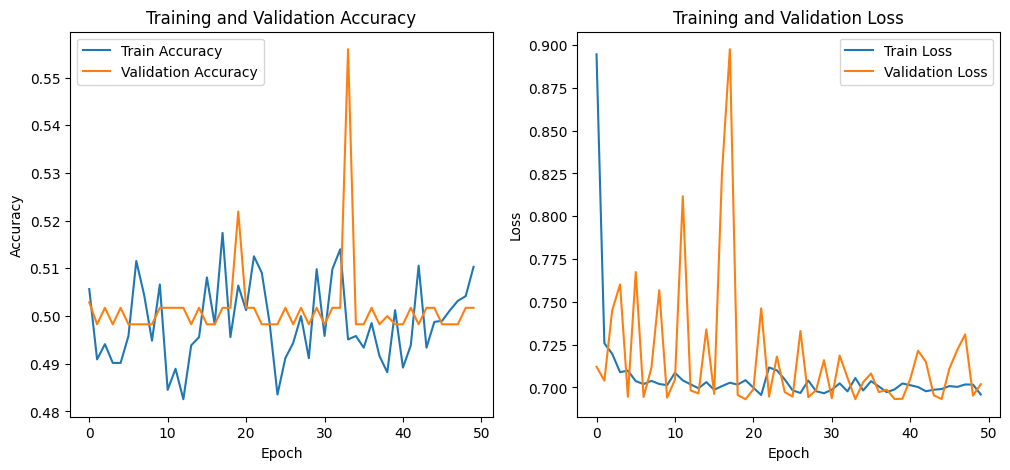

In [24]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
